In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pyro
import pyro.distributions as dist
from pyro.distributions import Categorical, Normal, Multinomial, Binomial, MultivariateNormal, Beta
from pyro.distributions.torch import Bernoulli
import pyro.infer as infer
from pyro.distributions import constraints
import pyro.infer as infer      

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
pyro.set_rng_seed(0)
np.random.seed(0)
mu = torch.tensor([-0.5, 6.0])
std = torch.tensor([0.75, np.sqrt(2.0)])
weights = torch.tensor([0.4, 0.6])
nsamples = 100
x = np.random.uniform(-10, 10, nsamples)
x.sort()
normal = Normal(mu, std)
samples = normal.sample((nsamples,))
y = normal.log_prob(torch.from_numpy(x).float().unsqueeze_(1).expand(nsamples, 2)).exp()
mixture = weights[0] * y[:, 0] + weights[1] * y[:, 1]


In [3]:
mixture

tensor([5.7414e-29, 5.2969e-28, 6.5067e-28, 6.6201e-28, 1.2305e-26, 2.8969e-25,
        5.1755e-25, 1.4281e-24, 1.5651e-23, 4.5902e-23, 6.5734e-23, 7.7976e-23,
        1.8879e-22, 1.0034e-21, 5.8729e-21, 6.5237e-21, 9.1882e-21, 7.2915e-20,
        1.4480e-19, 6.6188e-19, 2.2387e-18, 8.0704e-17, 1.3620e-16, 1.5108e-14,
        2.2814e-13, 2.4658e-12, 3.2761e-12, 1.3136e-09, 5.4659e-09, 3.0855e-08,
        3.4947e-08, 4.2080e-07, 1.0210e-06, 2.4435e-06, 2.4889e-05, 3.3182e-05,
        3.5420e-05, 1.8546e-03, 2.6027e-03, 3.8360e-03, 1.0801e-02, 5.7315e-02,
        5.8308e-02, 8.3333e-02, 1.2744e-01, 1.2935e-01, 1.3284e-01, 1.8752e-01,
        1.9938e-01, 2.0714e-01, 2.0974e-01, 9.7573e-02, 9.3072e-02, 7.5859e-02,
        3.7732e-02, 3.0969e-02, 1.1499e-02, 1.0576e-02, 1.0341e-02, 9.3437e-03,
        6.7983e-03, 4.3319e-03, 4.1014e-03, 4.2845e-03, 5.2225e-03, 6.0953e-03,
        6.2380e-03, 1.3065e-02, 1.5752e-02, 1.9567e-02, 2.1486e-02, 2.8684e-02,
        2.9178e-02, 3.1752e-02, 4.1879e-

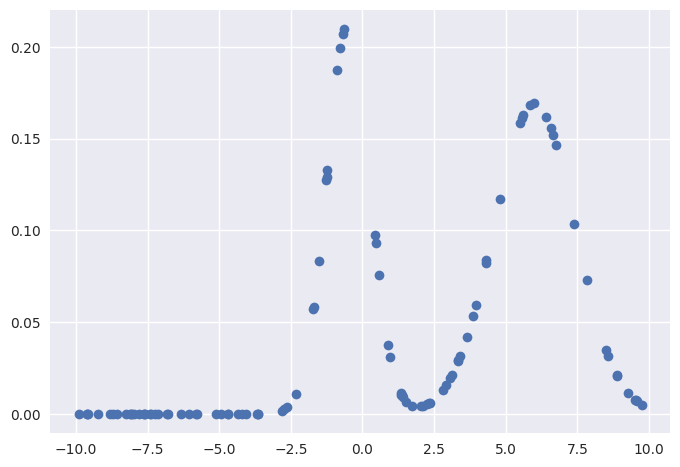

In [4]:
plt.plot(x, mixture, "o")

In [5]:
data = {"x": x, "y": y, "mixture": mixture,"weights": weights, "samples": samples}

In [6]:
def model(data):
    x, y, mixture, weights, samples = data["x"], data["y"], data["mixture"], data["weights"], data["samples"]
    with pyro.plate("data", x.shape[0]):
        return pyro.sample("normal", dist.Normal(mu, std).to_event(1), obs=samples)


def guide(data):
    x, y, mixture, weights = data["x"], data["y"], data["mixture"], data["weights"]
    locs = pyro.param("locs", lambda: torch.tensor([-0.2, 0.3]))
    scales = pyro.param("scales", lambda: torch.tensor([1.6, 1.0]), constraint=constraints.positive)
    with pyro.plate("data", x.shape[0]):
        samples = pyro.sample("normal", dist.Normal(locs, scales).to_event(1))


In [7]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
svi = infer.SVI(model, guide, optim, infer.Trace_ELBO())

In [8]:

losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    

/env_nlp/lib/python3.9/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'normal'}
  warnings.warn(


In [9]:
for name, value in pyro.get_param_store().items():
    print(name, value)

locs tensor([-0.2000,  0.3000], requires_grad=True)
scales tensor([4.3493, 2.7183], grad_fn=<AddBackward0>)


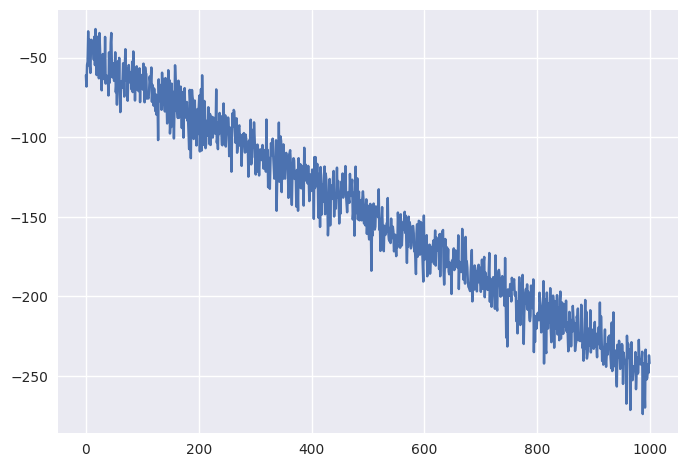

In [10]:
plt.plot(losses)